# SINDy example code

In [1]:
import numpy as np
from scipy.integrate import odeint
from sklearn.model_selection import KFold, GridSearchCV

from context import sindy
from sindy import SINDy
from sindy.differentiation import differentiation_methods
from sindy.optimizers import STLSQ, SR3

import matplotlib.pyplot as plt
%matplotlib inline

## Generate training data

### harmonic oscillator

In [2]:
def rhs_harmonic_oscillator(y, t):
    dy0 = y[1]
    dy1 = -0.3 * y[0]
    return [dy0, dy1]

In [3]:
n_points = 1000

x0 = [0, 1]
t = np.linspace(0, 10, n_points)
x = odeint(rhs_harmonic_oscillator, x0, t)

train_idx = int(n_points * 0.75)
x_train, x_test = x[:train_idx], x[train_idx:]
t_train, t_test = t[:train_idx], t[train_idx:]

### lorenz

In [4]:
lorenz = lambda z,t : [10*(z[1] - z[0]), z[0]*(28 - z[2]) - z[1], z[0]*z[1] - 8/3*z[2]]

In [5]:
n_points = 1000

x0 = [8,27,-7]
t = np.linspace(0, 10, n_points)
x = odeint(lorenz, x0, t)

train_idx = int(n_points * 0.75)
x_train, x_test = x[:train_idx], x[train_idx:]
t_train, t_test = t[:train_idx], t[train_idx:]

## Basic examples

### Simplest version

In [6]:
model = SINDy()
model.fit(x_train, t_train)

SINDy(differentiation_method=<function centered_difference at 0x7f51b9d4e378>,
   feature_library=PolynomialFeatures(degree=2, include_bias=True, interaction_only=False),
   feature_names=None, n_jobs=1,
   optimizer=STLSQ(alpha=0.0, ridge_kw=None, threshold=0.1))

In [7]:
print(model.equations())

['-9.961 x0 + 9.961 x1', '27.559 x0 + -0.922 x1 + -0.988 x0 x2', '-2.648 x2 + 0.993 x0 x1']


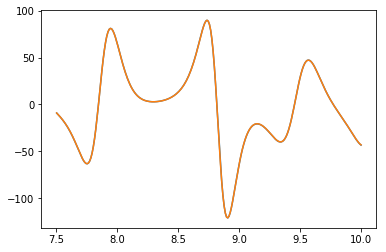

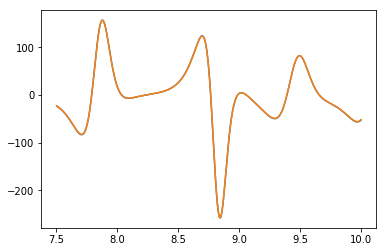

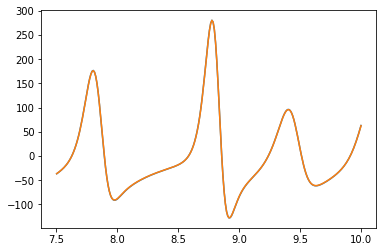

In [8]:
for i in range(x_test.shape[1]):
    plt.figure()
    plt.plot(t_test, differentiation_methods.centered_difference(x_test, t_test)[:,i])
    plt.plot(t_test, model.predict(x_test)[:,i])

## Change some options

In [9]:
from sindy.optimizers import STLSQ, SR3, LASSO
from sklearn.preprocessing import PolynomialFeatures

### SR3

['-0.279  + -10.112 x0 + 10.080 x1', '1.419  + 27.555 x0 + -0.851 x1 + -0.139 x2 + -0.987 x0 x2', '-0.245 x0 + 0.250 x1 + -2.593 x2 + 0.985 x0 x1']


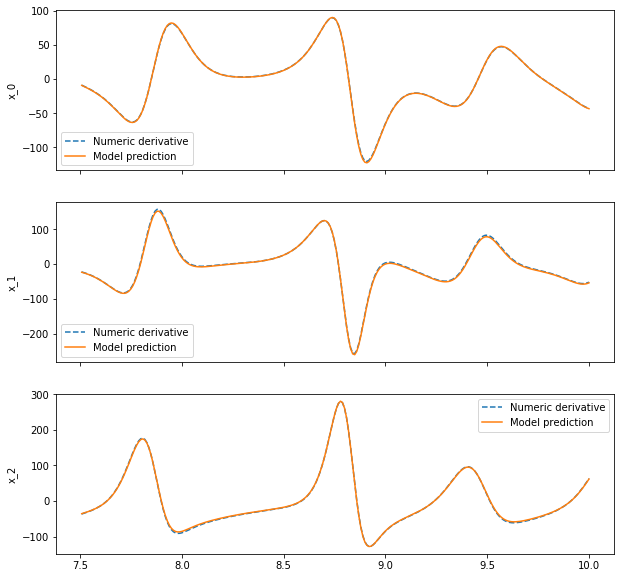

In [10]:
model = SINDy(optimizer=SR3())
model.fit(x_train, t_train)

print(model.equations())

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(10, 10))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, differentiation_methods.centered_difference(x_test, t_test)[:,i], '--', label='Numeric derivative')
    axs[i].plot(t_test, model.predict(x_test)[:,i], label='Model prediction')
    axs[i].legend()
    axs[i].set(ylabel='x_{}'.format(i))

fig.show()

### LASSO

/home2/bdesilva/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home2/bdesilva/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home2/bdesilva/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


['-0.279  + -10.112 x0 + 10.080 x1 + 0.040 x2 + 0.004 x0^2 + -0.001 x0 x1 + 0.004 x0 x2 + -0.001 x1^2 + -0.003 x1 x2 + -0.001 x2^2', '1.419  + 27.555 x0 + -0.851 x1 + -0.139 x2 + -0.015 x0^2 + 0.023 x0 x1 + -0.987 x0 x2 + -0.011 x1^2 + -0.004 x1 x2 + 0.004 x2^2', '-0.097  + -0.246 x0 + 0.250 x1 + -2.592 x2 + 0.020 x0^2 + 0.985 x0 x1 + 0.007 x0 x2 + -0.002 x1^2 + -0.009 x1 x2 + -0.003 x2^2']


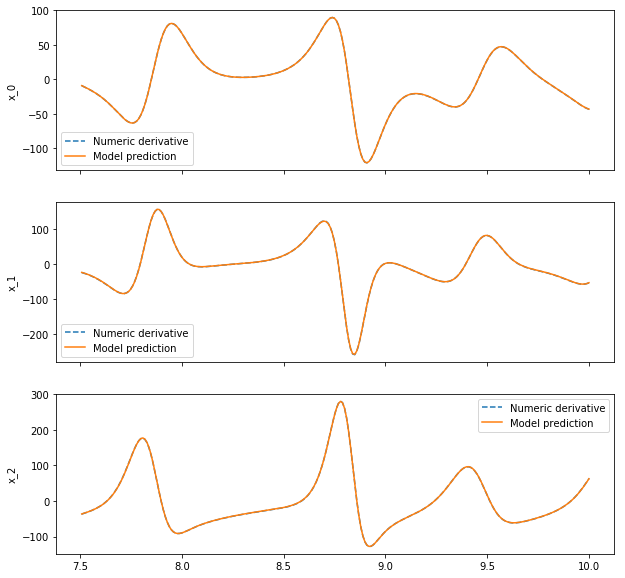

In [11]:
model = SINDy(optimizer=LASSO(max_iter=1000))
model.fit(x_train, t_train)

print(model.equations())

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(10, 10))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, differentiation_methods.centered_difference(x_test, t_test)[:,i], '--', label='Numeric derivative')
    axs[i].plot(t_test, model.predict(x_test)[:,i], label='Model prediction')
    axs[i].legend()
    axs[i].set(ylabel='x_{}'.format(i))

fig.show()